### Installing and importing libraries

In [15]:
# installations
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.multiclass import unique_labels

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/edakavlakoglu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/edakavlakoglu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edakavlakoglu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading the data

In [6]:
data = pd.read_csv("~/Documents/Code/SMSSpamCollection.csv")
data.head()

,classification,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
data.shape

(5572, 4)

### Exploratory data analysis

In [7]:
#recoding dataset 
data['target'] = np.where(data['classification']=='ham',0, 1)

In [8]:
#check for duplicate data
data['duplicates'] = np.where(data['text'].duplicated(keep=False), 1, 0)

In [11]:
print('Top 5 common duplicate texts are:')
data[data.duplicates == 1].pivot_table(index='text', values='target', aggfunc='count').sort_values(by='target', ascending=False).head(5)

Top 5 common duplicate texts are:


,target
text,
"Sorry, I'll call later",30
I cant pick the phone right now. Pls send a message,12
Ok...,10
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4


In [10]:
#check for missing data
print("Missing data in each column:\n" + str(data.isnull().sum()))

Missing data in each column:
classification    0
text              0
target            0
duplicates        0
dtype: int64


In [12]:
data['target'].value_counts()


target
0    4825
1     747
Name: count, dtype: int64

/Users/edakavlakoglu/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edakavlakoglu/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edakavlakoglu/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


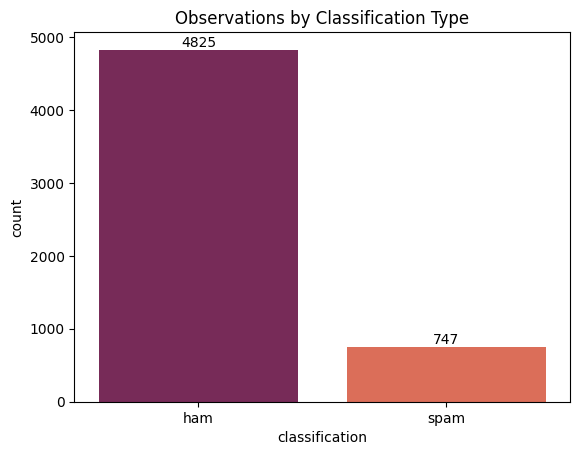

In [13]:
# Explore distribution of dataset 

# count plot on single categorical variable
ax = sns.countplot(x = data['classification'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

Note: Distribution of dataset indicates imbalanced data.

In [14]:
# Dropping all duplicate texts based off of results of EDA
df_no_dup = data.drop_duplicates(subset=['text'], keep='first')

/Users/edakavlakoglu/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edakavlakoglu/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edakavlakoglu/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


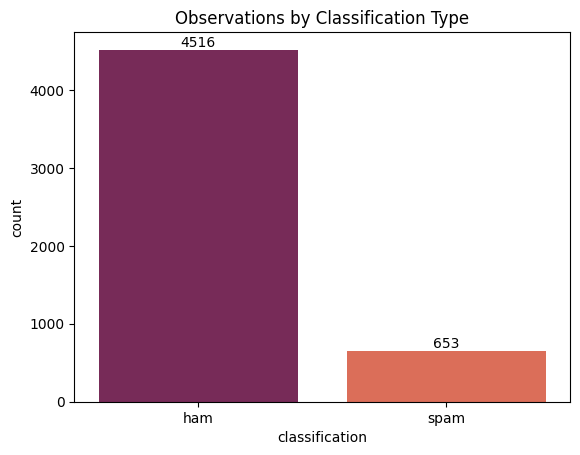

In [15]:
# Explore distribution of dataset 

# count plot on single categorical variable
ax = sns.countplot(x = df_no_dup['classification'], palette = 'rocket')

#add data labels
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

### Data splitting

In [16]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, Y_train, Y_test = train_test_split(df_no_dup['text'], 
                                                    df_no_dup['target'],
                                                    test_size=0.3,
                                                    random_state=0)

### Data preparation and data cleaning

In [18]:
def text_clean(text, method, rm_stop):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase 
    text = re.sub(r"\d+","",text)   #remove digits and currencies 
    text = re.sub(r'[\$\d+\d+\$]', "", text)      
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   #remove dates 
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)   #remove hyperlinks
    
    #remove stop words 
    if rm_stop == True:
        filtered_tokens = [word for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
        text = " ".join(filtered_tokens)
        
    #lemmatization: typically preferred over stemming
    if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)
    
    #stemming 
    if method == 'S':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in word_tokenize(text)]
        return " ".join(stem_tokens)
    
    return text

In [81]:
#preprocessed data: Lemm + stopword removal 
preprocessed_text_1 = [text_clean(text, 'L', True) for text in X_train]
#preprocessed_text_1[0:10]

#preprocessed data: Lemm + no stopword removal 
preprocessed_text_2 = [text_clean(text, 'L', False) for text in X_train]
#preprocessed_text_2[0:10]

#preprocessed data: Stem + stopword removal 
preprocessed_text_3 = [text_clean(text, 'S', True) for text in X_train]
#preprocessed_text_3[0:10]

#preprocessed data: Stem + no stopword removal 
preprocessed_text_4 = [text_clean(text, 'S', False) for text in X_train]
#preprocessed_text_4[0:10]

In [125]:
def transform_model_data_w_count_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset 
    vectorizer = CountVectorizer()
    vectorized_data = vectorizer.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions



In [129]:
def transform_model_data_w_tfidf_vectorizer(preprocessed_text, Y_train,  X_test, Y_test):
    #vectorize dataset 
    tfidf = TfidfVectorizer() 
    vectorized_data = tfidf.fit_transform(preprocessed_text)

    #define model
    model = MultinomialNB(alpha=0.1)
    model.fit(vectorized_data, Y_train)
 
    #evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions

In [124]:
#vectorize, model, and evaluate model using CountVectorizer

#Lemm + stopword removal 
print("Lemm + stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

#Lemm + no stopword removal 
print("\nLemm + no stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

#Stem + stopword removal 
print("\nStem + stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test)

#Stem + no stopword removal 
print("\nStem + no stopword removal + CountVectorizer") 
transform_model_data_w_count_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Lemm + stopword removal + CountVectorizer
Accuracy: 97.55 %
Balanced accuracy: 94.57 %
Precision: 90.55 %

Lemm + no stopword removal + CountVectorizer
Accuracy: 97.42 %
Balanced accuracy: 93.86 %
Precision: 90.86 %

Stem + stopword removal + CountVectorizer
Accuracy: 96.91 %
Balanced accuracy: 90.6 %
Precision: 93.22 %

Stem + no stopword removal + CountVectorizer
Accuracy: 97.29 %
Balanced accuracy: 91.88 %
Precision: 93.92 %


In [120]:
#vectorize, model, and evaluate model using TfidfVectorizer

#Lemm + stopword removal 
print("Lemm + stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test)

#Lemm + no stopword removal 
print("\nLemm + no stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test)

#Stem + stopword removal 
print("\nStem + stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test)

#Stem + no stopword removal 
print("\nStem + no stopword removal + TfidfVectorizer") 
transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Lemm + stopword removal + TfidfVectorizer
Accuracy: 97.36 %
Balanced accuracy: 91.92 %
Precision: 94.44 %

Lemm + no stopword removal + TfidfVectorizer
Accuracy: 97.61 %
Balanced accuracy: 92.07 %
Precision: 96.59 %

Stem + stopword removal + TfidfVectorizer
Accuracy: 96.07 %
Balanced accuracy: 85.46 %
Precision: 97.95 %

Stem + no stopword removal + TfidfVectorizer
Accuracy: 96.45 %
Balanced accuracy: 86.53 %
Precision: 99.32 %


In [130]:
predictions = transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test)

Accuracy: 96.45 %
Balanced accuracy: 86.53 %
Precision: 99.32 %


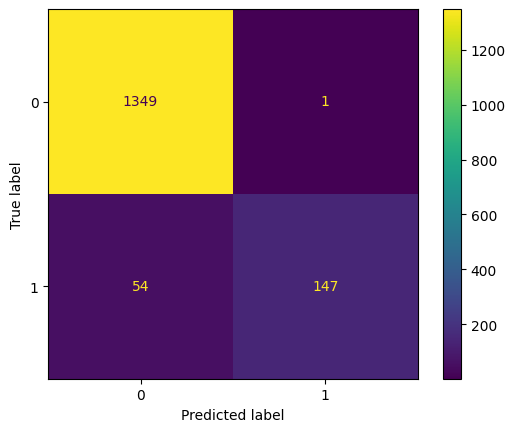

In [132]:
#compute the confusion matrix.
cm = confusion_matrix(Y_test, predictions)

 #Plot the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()